Importing Libraries

In [1]:
import os
import numpy as np
from utils import datapipeline # file named datapipeline cosisting of our custom dataloader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Initializing Data Loader

In [2]:
##############################################################
#Define the image generators for training and validation
train_img_dir = "/home/abul/Downloads/input_data_128/train/images/"
train_mask_dir = "/home/abul/Downloads/input_data_128/train/masks/"

val_img_dir = "/home/abul/Downloads/input_data_128/val/images/"
val_mask_dir = "/home/abul/Downloads/input_data_128/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))


batch_size = 1

train_img_datagen = datapipeline.imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = datapipeline.imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

Verify generator

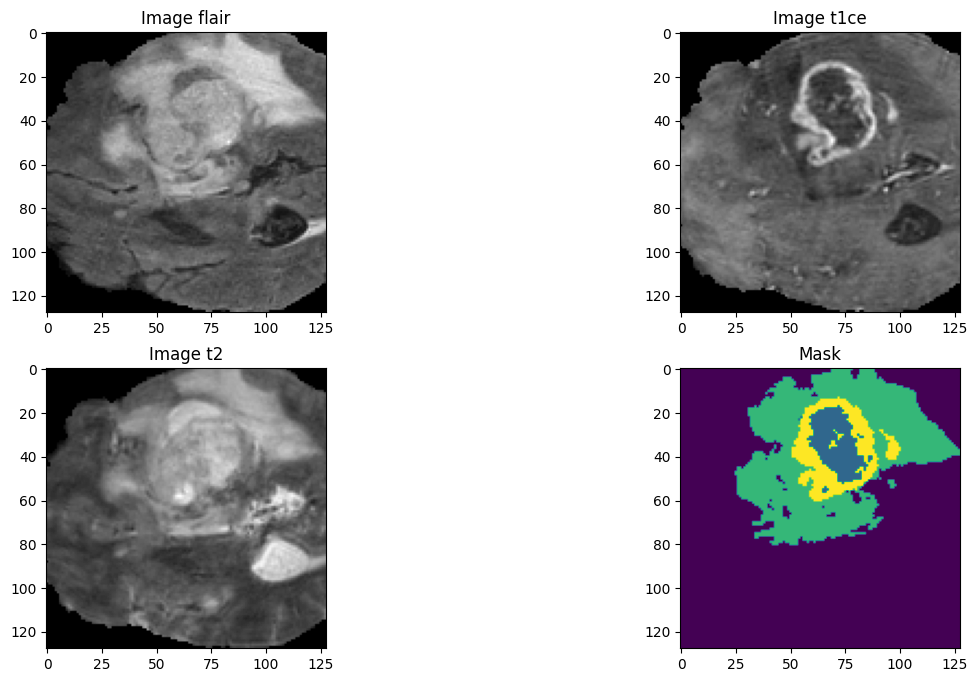

In [12]:
# Verify generator
img, msk = train_img_datagen.__next__()

img_num = int(input("Enter num of image you wan to view : ")) #only enter number in range of batch size here its 2 [0,1]
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=int(input("Enter slice number : ")) # 0 - 128 
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


Defining Loss & Optimizer

In [ ]:
#Define loss, metrics and optimizer to be used for training
from utils import losses
def loss(y_true, y_pred):

    return losses.DiceLoss()(y_true, y_pred)

# Define metrics
num_classes = 4
metrics = [
    'accuracy',
    tf.keras.metrics.MeanIoU(num_classes=num_classes),
    tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=[0, 1, 2, 3])
]

LR = 0.0001
optimizer= keras.optimizers.Adam(LR)

Initializing the model

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

from utils import UNET_Attn as UNET
model = UNET(IMG_HEIGHT=128, 
            IMG_WIDTH=128, 
            IMG_DEPTH=128, 
            IMG_CHANNELS=3, 
            num_classes=4)

model.compile(optimizer = optimizer, loss=loss, metrics=metrics)

Training

In [57]:
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.6210 - iou_score: 0.1788 - mean_io_u_4: 0.3750
Epoch 1: val_loss did not improve from 0.75130
121/121 [==============================] - 194s 1s/step - loss: 0.7858 - accuracy: 0.6210 - iou_score: 0.1788 - mean_io_u_4: 0.3750 - val_loss: 0.9163 - val_accuracy: 0.1853 - val_iou_score: 0.0478 - val_mean_io_u_4: 0.3750
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7517 - iou_score: 0.2826 - mean_io_u_4: 0.3750
Epoch 2: val_loss did not improve from 0.75130
121/121 [==============================] - 169s 1s/step - loss: 0.7055 - accuracy: 0.7517 - iou_score: 0.2826 - mean_io_u_4: 0.3750 - val_loss: 0.7711 - val_accuracy: 0.4927 - val_iou_score: 0.1955 - val_mean_io_u_4: 0.3750
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.7632 - iou_score: 0.2987 - mean_io_u_4: 0.3750
Epoch 3: val_loss improved from 0.75130 t

Results

Epoch 1: Training Accuracy: 0.6209621429443359, Training IOU: 0.17878417670726776, Training Mean IOU: 0.375, Validation Accuracy: 0.185270756483078, Validation IOU: 0.047755494713783264, Validation Mean IOU: 0.375
Epoch 2: Training Accuracy: 0.7516570091247559, Training IOU: 0.28255173563957214, Training Mean IOU: 0.375, Validation Accuracy: 0.49266037344932556, Validation IOU: 0.19545282423496246, Validation Mean IOU: 0.375
Epoch 3: Training Accuracy: 0.7632447481155396, Training IOU: 0.29873281717300415, Training Mean IOU: 0.375, Validation Accuracy: 0.6148790717124939, Validation IOU: 0.24481065571308136, Validation Mean IOU: 0.375
Epoch 4: Training Accuracy: 0.7747092247009277, Training IOU: 0.3085319697856903, Training Mean IOU: 0.375, Validation Accuracy: 0.6089363694190979, Validation IOU: 0.2649850845336914, Validation Mean IOU: 0.375
Epoch 5: Training Accuracy: 0.7841392159461975, Training IOU: 0.3231216371059418, Training Mean IOU: 0.375, Validation Accuracy: 0.53892254829406

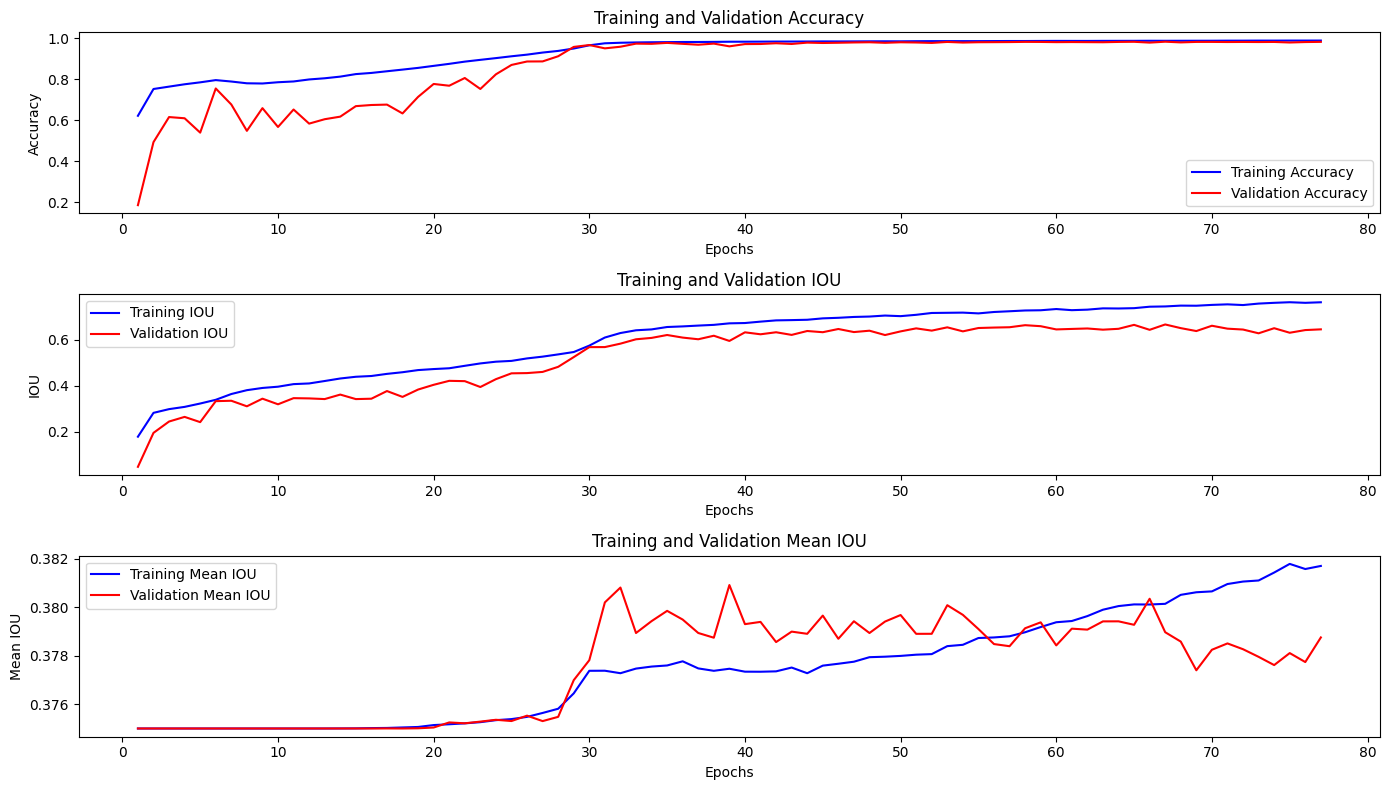

In [58]:
import csv
import matplotlib.pyplot as plt

# Define a list to store training results
training_results = []

# Extract training metrics from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
training_iou_score = history.history['iou_score']
training_mean_iou = history.history['mean_io_u_4']  # Adjust the metric name as needed

# Extract validation metrics from the history object (assuming it contains validation data)
validation_accuracy = history.history['val_accuracy']
validation_iou_score = history.history['val_iou_score']
validation_mean_iou = history.history['val_mean_io_u_4']  # Adjust the metric name as needed

# Append the training results to the list and print each value
for epoch, training_acc, training_iou, training_miou, val_acc, val_iou, val_miou in zip(epochs, training_accuracy, training_iou_score, training_mean_iou, validation_accuracy, validation_iou_score, validation_mean_iou):
    training_results.append([epoch, training_acc, training_iou, training_miou, val_acc, val_iou, val_miou])
    print(f"Epoch {epoch}: Training Accuracy: {training_acc}, Training IOU: {training_iou}, Training Mean IOU: {training_miou}, Validation Accuracy: {val_acc}, Validation IOU: {val_iou}, Validation Mean IOU: {val_miou}")

# Define the training CSV file path
training_csv_file = '/kaggle/working/training_and_val_metrics.csv'

# Write the training results to a CSV file
with open(training_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Accuracy', 'Training IOU', 'Training Mean IOU',  'Validation Accuracy', 'Validation IOU', 'Validation Mean IOU'])
    writer.writerows(training_results)

print(f'Training results saved to {training_csv_file}')

# Plot the metrics
plt.figure(figsize=(14, 8))

# Plot training accuracy vs validation accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training IOU vs validation IOU
plt.subplot(3, 1, 2)
plt.plot(epochs, training_iou_score, 'b', label='Training IOU')
plt.plot(epochs, validation_iou_score, 'r', label='Validation IOU')
plt.title('Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

# Plot training Mean IOU vs validation Mean IOU
plt.subplot(3, 1, 3)
plt.plot(epochs, training_mean_iou, 'b', label='Training Mean IOU')
plt.plot(epochs, validation_mean_iou, 'r', label='Validation Mean IOU')
plt.title('Training and Validation Mean IOU')
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def dice_score(o, t, eps=1e-8):
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den
def softmax_output_dice(target,output):
    ret = []
    # whole   wt
    o = output > 0; t = target > 0 # ce
    ret += dice_score(o, t),
    # core   tc
    o = (output == 1) | (output == 3)
    t = (target == 1) | (target == 3)
    ret += dice_score(o, t),
    # active   et
    o = (output == 3);t = (target == 3)
    ret += dice_score(o, t),
    return ret
dice_scores_wt = []
dice_scores_tc = []
dice_scores_et = []
num_classes = 4
for batch in range(test_steps_per_epoch):
    test_img, test_mask = next(test_img_datagen)
    test_prediction = model.predict(test_img)
    
    test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
    
    tensor = softmax_output_dice(test_mask_argmax, test_prediction_argmax)
    dice_batch = tensor[0]
    dice_scores_wt.append(dice_batch)
    dice_scores_tc.append(tensor[1])
    dice_scores_et.append(tensor[2])
print("Dice Scores for Unet trained for 150 epochs with dice loss and focal loss:")
average_dice_score_et = sum(dice_scores_et) / len(dice_scores_et)
print("Average Dice Score et:", average_dice_score_et)
average_dice_score_wt = sum(dice_scores_wt) / len(dice_scores_wt)
print("Average Dice Score wt:", average_dice_score_wt)
average_dice_score_tc = sum(dice_scores_tc) / len(dice_scores_tc)
print("Average Dice Score tc:", average_dice_score_tc)
import csv

average_dice_scores = [
    ['Enhanced Tumor', average_dice_score_et],
    ['Whole Tumor', average_dice_score_wt],
    ['Tumor Core', average_dice_score_tc]
]
# Define the CSV file path
test_csv_file = '/kaggle/working/dice_scores.csv'
# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(average_dice_scores)

print(f'dice scores results saved to {test_csv_file}')

In [63]:
model.save('unet_attn.keras')

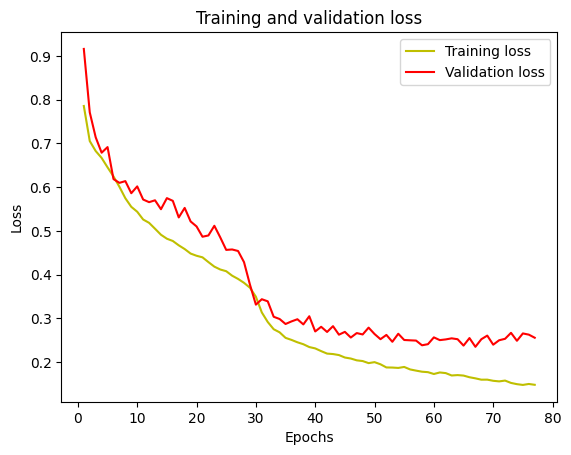

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loading Model for Testing

In [69]:
import tensorflow as tf
from keras.losses import Loss
from keras.utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"loss": loss})
get_custom_objects().update({"io_u_2": tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=[0, 1, 2, 3])})
get_custom_objects().update({"mean_io_u_2": tf.keras.metrics.MeanIoU(num_classes=4)})   
my_model = load_model('unet_attn.keras')

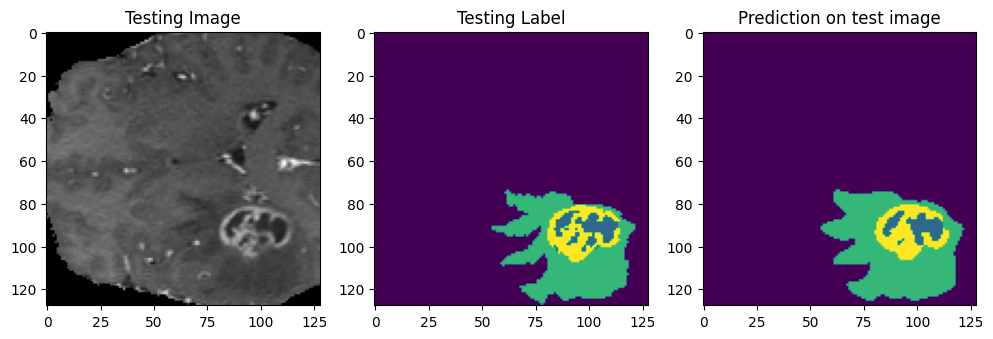

In [71]:
from matplotlib import pyplot as plt
import random
img_num = 82

test_img = np.load("/kaggle/input/brats701515/input_data_128/test/images/image_"+str(img_num)+".npy")
test_mask = np.load("/kaggle/input/brats701515/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()